# Cvičení 05a— MLP v PyTorch (Replikace 'NN from Scratch')

O co tady jde:
- Cílem tohoto cvičení je replikovat funkcionalitu MLP pro klasifikaci na datasetu Two Moons, kterou jsme implementovali "od nuly", ale tentokrát s využitím knihovny PyTorch.

## 1) Knihovny a příprava dat

Nastavíme potřebné knihovny a připravíme data Two Moons pro PyTorch (konverze na Tenzory).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Nastavení seed pro reprodukovatelnost
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# 1. Generování dat Two Moons
X_np, y_np = make_moons(n_samples=1000, noise=0.15, random_state=42)

# 2. Rozdělení na trénovací a testovací sady
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42
)

# 3. Konverze na PyTorch Tenzory
# X data musí být float
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)

# y labely musí být long (indexy tříd pro CrossEntropyLoss)
y_train = torch.tensor(y_train_np, dtype=torch.long)
y_test = torch.tensor(y_test_np, dtype=torch.long)

print(f"Trénovací data (X, y): {X_train.shape}, {y_train.shape}")
print(f"Testovací data (X, y): {X_test.shape}, {y_test.shape}")

Trénovací data (X, y): torch.Size([800, 2]), torch.Size([800])
Testovací data (X, y): torch.Size([200, 2]), torch.Size([200])


## 2) Definice MLP modelu

Definujeme třídu modelu, která dědí z `nn.Module`.

`nn.Linear(in, out)`: Implementuje lineární vrstvu ($z=xW+b$).

`nn.ReLU()`: Implementuje aktivační funkci.

In [3]:
class TwoMoonsMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoMoonsMLP, self).__init__()

        # 1. Lineární vrstva: Vstup (2) -> Skrytá (16)
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Aktivace
        self.relu = nn.ReLU()

        # 2. Lineární vrstva: Skrytá (16) -> Výstup (2 logity)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Dopředný průchod
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x) # Finální logity 'z'
        return x

# Inicializace modelu
INPUT_DIM = X_train.shape[1]
OUTPUT_DIM = len(np.unique(y_np))
HIDDEN_DIM = 16

model = TwoMoonsMLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
print(model)

TwoMoonsMLP(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)


## 3) Nastavení trénování (Loss & Optimizer)

Použijeme vestavěný **CrossEntropyLoss** a **Adam** optimalizátor.

In [4]:
# Loss funkce: nn.CrossEntropyLoss (ekvivalent naší SoftmaxCE)
criterion = nn.CrossEntropyLoss()

# Optimalizátor: Použijeme Adam
optimizer = optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 300
BATCH_SIZE = 32

## 4) Trénovací smyčka

Základní trénovací smyčka s manuálním voláním `zero_grad()`, `backward()` a `optimizer.step()`.

In [5]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    # --- Trénovací fáze (model.train()) ---
    model.train()

    optimizer.zero_grad() # 1. Vynulování gradientů

    outputs = model(X_train) # 2. Dopředný průchod (outputs jsou logity)
    loss = criterion(outputs, y_train) # 3. Výpočet ztráty

    loss.backward() # 4. Zpětný průchod (Backpropagation)
    optimizer.step() # 5. Aktualizace vah

    train_losses.append(loss.item())

    # --- Testovací fáze (model.eval()) ---
    model.eval()
    with torch.no_grad(): # Vypnutí počítání gradientů
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 50 == 0:
        # Přesnost: Z logitů najdeme maximální (predicted) třídu
        _, predicted = torch.max(test_outputs.data, 1)
        test_acc = accuracy_score(y_test_np, predicted.numpy())
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Test Acc: {test_acc:.4f}')

Epoch [50/300], Train Loss: 0.2521, Test Acc: 0.9000
Epoch [100/300], Train Loss: 0.1904, Test Acc: 0.9200
Epoch [150/300], Train Loss: 0.1231, Test Acc: 0.9650
Epoch [200/300], Train Loss: 0.0820, Test Acc: 0.9850
Epoch [250/300], Train Loss: 0.0583, Test Acc: 0.9850
Epoch [300/300], Train Loss: 0.0467, Test Acc: 0.9950


## 5) Vizualizace výsledků

Vykreslení ztráty a rozhodovací hranice.

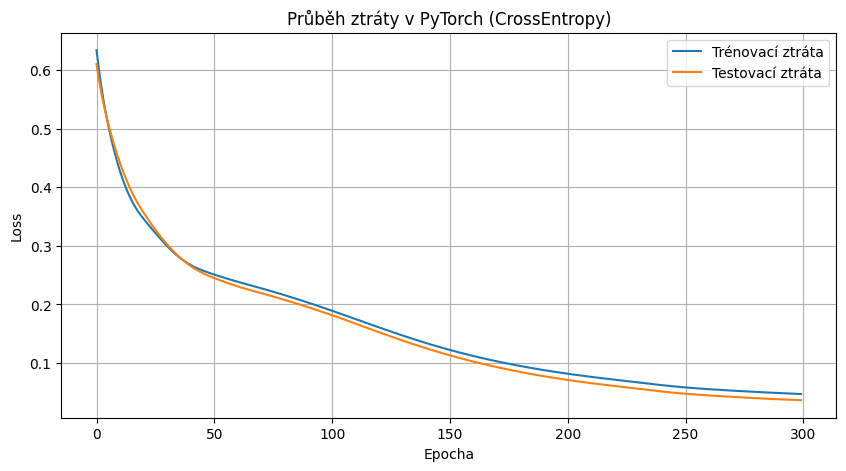

In [6]:
# Vykreslení trénovací a testovací ztráty
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Trénovací ztráta')
plt.plot(test_losses, label='Testovací ztráta')
plt.title('Průběh ztráty v PyTorch (CrossEntropy)')
plt.xlabel('Epocha')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

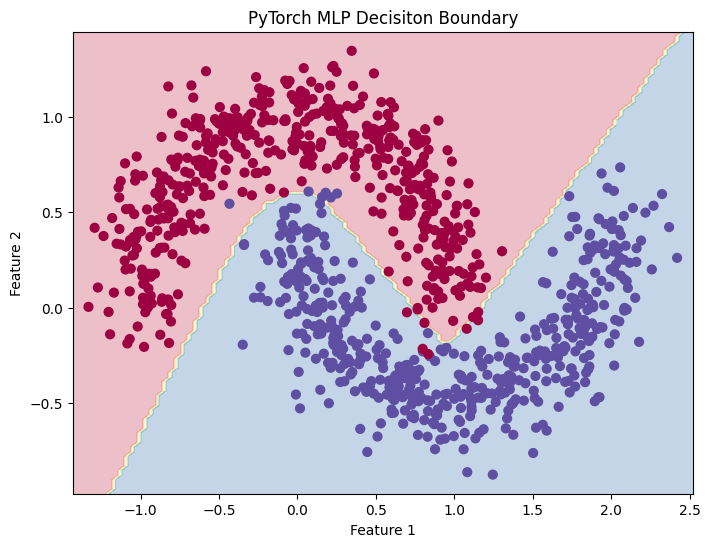

In [7]:
def plot_decision_boundary_pytorch(model, X_np, y_np):
    """Vykreslí rozhodovací hranici pro 2D PyTorch model."""
    x_min, x_max = X_np[:, 0].min() - 0.1, X_np[:, 0].max() + 0.1
    y_min, y_max = X_np[:, 1].min() - 0.1, X_np[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        # Získání logitů a určení třídy (argmax)
        Z = model(grid_tensor)
        _, Z = torch.max(Z.data, 1)

    Z = Z.numpy().reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Spectral)
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, s=40, cmap=plt.cm.Spectral)
    plt.title('PyTorch MLP Decisiton Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

plot_decision_boundary_pytorch(model, X_np, y_np)

# Cvičení 05b — Generování textu pomocí Char-RNN

Tato úloha zavede rekurentní neuronové sítě (RNN), které jsou klíčové pro zpracování sekvencí a ukáže, jak se model učí předpovídat následující znak v textu (Language Modeling).

## 1. Příprava dat pro Char-RNN

Nejprve potřebujeme textový korpus (pro jednoduchost použijeme malý, vestavěný string) a potřebujeme ho konvertovat na číselné ID (tokeny).

In [8]:
try:
    import requests
    # URL pro stažení Romea a Julie (Plain text, Project Gutenberg)
    url = "https://www.gutenberg.org/cache/epub/1513/pg1513.txt"
    response = requests.get(url)

    # Získání obsahu a oříznutí hlaviček/patiček Project Gutenberg
    text = response.text
    start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***"
    end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***"

    start_index = text.find(start_marker) + len(start_marker)
    end_index = text.find(end_marker)

    corpus = text[start_index:end_index].strip()
    print("Úspěšně načten text 'Romeo a Julie' (délka cca 160 kB).")

except ImportError:
    print("Knihovna 'requests' není nainstalována. Používám zástupný text.")
    corpus = """
    Při trénování neuronových sítí je důležité používat data, která jsou
    reprezentativní a dostatečně velká. Rekurentní sítě se učí sekvence
    a vztahy mezi slovy, proto delší korpus, jako je Shakespeare,
    poskytuje mnohem lepší výsledky než krátké věty.
    """

# Standardizace korpusu:
# 1. Ponecháme velká písmena pro lepší wow-efekt, ale zjednodušíme mezery a interpunkci.
# 2. Nahradíme potenciálně rušivé znaky (např. v Shakespearovi) mezerami.
corpus = corpus.replace('\n', ' ').replace('\r', ' ').replace('--', ' ')
corpus = ' '.join(corpus.split())

# Vytvoření mapování (s ponecháním Case Sensitivity, aby se učil velká písmena na začátku vět)
char_to_ix = {ch: i for i, ch in enumerate(sorted(list(set(corpus))))}
ix_to_char = {i: ch for ch, i in char_to_ix.items()}
VOCAB_SIZE = len(char_to_ix)

# Konverze korpusu na tenzor indexů
data = torch.tensor([char_to_ix[ch] for ch in corpus], dtype=torch.long)

print(f"Velikost slovníku (VOCAB_SIZE): {VOCAB_SIZE}")
print(f"Délka korpusu (znaků): {len(corpus)}")


Úspěšně načten text 'Romeo a Julie' (délka cca 160 kB).
Velikost slovníku (VOCAB_SIZE): 69
Délka korpusu (znaků): 141104


## 2. Definice Char-RNN modelu

Definujeme model s věma vrstvami `nn.RNN` a **one-hot encodingem** na vstupu.

In [9]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. Embedding: Konverze indexů znaků na one-hot vektory (pro naivitu)
        # Běžné LM by zde použily nn.Embedding. Zde použijeme ruční one-hot.
        self.one_hot_size = vocab_size

        # 2. Rekurentní vrstva: nn.RNN
        # input_size je velikost one-hot vektoru (VOCAB_SIZE)
        self.rnn = nn.RNN(input_size=vocab_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True) # batch_first=True (Batch, Seq, Feature)

        # 3. Lineární vrstva: Skrytý stav -> Logity pro VOCAB_SIZE
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_seq, hidden):
        # Převod vstupních indexů na One-Hot (Batch, Sequence Length, Vocab Size)
        # PyTorch to umí rychle, ale implementujeme ručně pro pochopení
        input_one_hot = torch.nn.functional.one_hot(input_seq, num_classes=self.one_hot_size).float()

        # RNN průchod
        out, hidden = self.rnn(input_one_hot, hidden)

        # Poslední lineární vrstva (aplikovaná na všechny časové kroky)
        # out má tvar (Batch, Seq_len, Hidden_size)
        # Chceme logity pro každý znak v sekvenci, proto reshape
        out = self.fc(out.reshape(-1, self.hidden_size))

        return out, hidden

    def init_hidden(self, batch_size):
        # Inicializace nultého skrytého stavu (h0)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

## 3. Trénink a generování textu

Musíme vytvořit trénovací data jako sekvence `input -> target` a definovat funkci pro generování textu.

In [ ]:
# Hyperparametry
HIDDEN_SIZE = 256 # Znatelné navýšení kapacity
NUM_LAYERS = 2
LR = 0.001        # Snížené LR pro stabilní trénink na velkém korpusu
EPOCHS_RNN = 2000 # Minimálně 2000 epoch je doporučených pro smysluplný text

rnn_model = CharRNN(VOCAB_SIZE, HIDDEN_SIZE, NUM_LAYERS)
rnn_criterion = nn.CrossEntropyLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=LR)

# Vytvoření trénovacích párů (znak na pozici i+1 je cílem pro znak na pozici i)
input_seq = data[:-1].unsqueeze(0) # Tvar (1, Seq_len)
target_seq = data[1:].unsqueeze(0).reshape(-1) # Tvar (Seq_len)

print(f"Trénovací sekvence: {input_seq.shape}")

for epoch in range(1, EPOCHS_RNN + 1):
    rnn_model.train()
    rnn_optimizer.zero_grad()

    # Inicializace skrytého stavu (pro batch_size=1)
    hidden = rnn_model.init_hidden(batch_size=1)

    # Dopředný průchod
    outputs, hidden = rnn_model(input_seq, hidden)

    # Výpočet ztráty
    loss = rnn_criterion(outputs, target_seq)

    # Backpropagation a aktualizace
    loss.backward()
    rnn_optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{EPOCHS_RNN}], Loss: {loss.item():.4f}')

def generate_text(model, start_char, length):
    model.eval()

    # Inicializace
    generated_text = start_char
    input_char_idx = char_to_ix[start_char]
    input_seq = torch.tensor([[input_char_idx]], dtype=torch.long)
    hidden = model.init_hidden(batch_size=1)

    for _ in range(length):
        # Dopředný průchod jednoho znaku
        output, hidden = model(input_seq, hidden)

        # Získání pravděpodobností logitů a výběr následujícího znaku (zde argmax pro determinismus)
        # Pro kreativnější generování by se použil torch.multinomial

        # Získání logitů z posledního časového kroku a výběr nejvyšší pravděpodobnosti
        top_val, top_idx = output[-1].topk(1)

        next_char_idx = top_idx.item()
        next_char = ix_to_char[next_char_idx]

        # Aktualizace
        generated_text += next_char
        input_char_idx = next_char_idx
        input_seq = torch.tensor([[input_char_idx]], dtype=torch.long)

    return generated_text

print("\n--- Generování Textu (Zkusme předpovědět zbytek věty) ---")

# Generujeme zbytek věty (délka zbytku věty je 23 znaků)
generated = generate_text(rnn_model, start_char='R', length=500)
print(f"Trénovací korpus: '{corpus}'")
print(f"Generováno z 'R':  '{generated}'")

Trénovací sekvence: torch.Size([1, 141103])


## 4) Kreativita

V tomto kódu používáme `torch.multinomial` pro vzorkování z rozdělení pravděpodobnosti (Softmax výstupu), což zajišťuje, že model nevrací vždy jen tu nejpravděpodobnější odpověď.

In [ ]:
def generate_text_creative(model, start_char, length, temperature=0.8):
    """
    Generuje text pomocí multinomiálního vzorkování (s náhodností).
    Temperature: Řídí náhodnost. Nižší T = konzervativnější, vyšší T = kreativnější.
    """
    model.eval()

    generated_text = start_char
    input_char_idx = char_to_ix[start_char]
    input_seq = torch.tensor([[input_char_idx]], dtype=torch.long)
    hidden = model.init_hidden(batch_size=1)

    for _ in range(length):
        output, hidden = model(input_seq, hidden)

        # 1. Zavedení Temperature do logitů
        # Tím zvýrazníme rozdíly v pravděpodobnostech, pokud je T < 1.0
        output_logits = output[-1] / temperature

        # 2. Aplikace Softmax pro získání skutečných pravděpodobností
        probabilities = torch.nn.functional.softmax(output_logits, dim=0)

        # 3. Multinomiální vzorkování (náhodný výběr dle pravděpodobností)
        next_char_idx = torch.multinomial(probabilities, num_samples=1).item()
        next_char = ix_to_char[next_char_idx]

        # Aktualizace
        generated_text += next_char
        input_seq = torch.tensor([[next_char_idx]], dtype=torch.long)

    return generated_text

print("\n--- Generování Textu (KREATIVNÍ VÝSTUP) ---")

# Generujeme zbytek věty, začneme ' '
# Použijeme vyšší teplotu (např. 1.0) pro větší náhodnost
generated = generate_text_creative(
    model=rnn_model,
    start_char=' ',
    length=500,
    temperature=1
)

print(f"Trénovací korpus: '{corpus}'")
print(f"Generováno z 'T' (T=1.2):  '{generated}'")